All code pulled in reference to https://learn.deeplearning.ai/courses/building-multimodal-search-and-rag
course. For my own learning purposes I will deviate and make changes as needed.

In [1]:
# Import neural network training libraries
import torch
from torch import nn, optim
from torch.utils.data import DataLoader
from torchvision import transforms

# Import basic computation libraries along with data visualization and plotting libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
from sklearn.decomposition import PCA
import umap
import umap.plot
import plotly.graph_objs as go
import plotly.io as pio
pio.renderers.default = 'iframe'

# Import our data class which will organize MNIST and provide anchor, positive and negative samples.
# from mnist_dataset import MNISTDataset

/home/zhiyong/.pyenv/versions/3.10.4/envs/multimodal_rag/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/home/zhiyong/.pyenv/versions/3.10.4/envs/multimodal_rag/lib/python3.10/site-packages/numba/np/ufunc/dufunc.py:344: NumbaWarning: Compilation requested for previously compiled argument types ((uint32,)). This has no effect and perhaps indicates a bug in the calling code (compiling a ufunc more than once for the same signature
  warnings.warn(msg, errors.NumbaWarning)
/home/zhiyong/.pyenv/versions/3.10.4/envs/multimodal_rag/lib/python3.10/site-packages/numba/np/ufunc/dufunc.py:344: NumbaWarning: Compilation requested for previously compiled argument types ((uint32,)). This has no effect and perhaps indicates a bug in the calling code (compiling a ufunc more than once for the same signature
  warnings.

In [2]:
# Code copied 
import pandas as pd
from torch.utils.data import Dataset
import numpy as np
from tqdm import tqdm

class MNISTDataset(Dataset):
    def __init__(self, data_df: pd.DataFrame, transform=None, is_test=False):
        # method will run once when class object is created.
        # method will create data at the time of object creation.
        # this will save time of training
        super(MNISTDataset, self).__init__()
        dataset = []
        labels_positive = {}
        labels_negative = {}
        if is_test == False:
            # for each label create a set of same label images.
            for i in list(data_df.label.unique()):
                labels_positive[i] = data_df[data_df.label == i].to_numpy()
            # for each label create a set of image of different label.
            for i in list(data_df.label.unique()):
                labels_negative[i] = data_df[data_df.label != i].to_numpy()

        for i, row in tqdm(data_df.iterrows(), total=len(data_df)):
            data = row.to_numpy()
            # if test then only image will be returned.
            if is_test:
                label = -1
                first = data.reshape(28, 28)
                second = -1
                dis = -1
            else:
                # label and image of the index for each row in df
                label = data[0]
                first = data[1:].reshape(28, 28)
                # probability of same label image == 0.5
                if np.random.randint(0, 2) == 0:
                    # randomly select same label image
                    second = labels_positive[label][
                        np.random.randint(0, len(labels_positive[label]))
                    ]
                else:
                    # randomly select different(negative) label 
                    second = labels_negative[label][
                        np.random.randint(0, len(labels_negative[label]))
                    ]
                # cosine is 1 for same and 0 for different label
                dis = 1.0 if second[0] == label else 0.0
                # reshape image
                second = second[1:].reshape(28, 28)

            # apply transform on both images
            if transform is not None:
                first = transform(first.astype(np.float32))
                if second is not -1:
                    second = transform(second.astype(np.float32))

            # append to dataset list. 
            # this random list is created once and used in every epoch
            dataset.append((first, second, dis, label))
        
        self.dataset = dataset
        self.transform = transform
        self.is_test = is_test

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, i):
        return self.dataset[i]

<>:55: SyntaxWarning:

"is not" with a literal. Did you mean "!="?

<>:55: SyntaxWarning:

"is not" with a literal. Did you mean "!="?

/tmp/ipykernel_240944/84635887.py:55: SyntaxWarning:

"is not" with a literal. Did you mean "!="?



What's important in the creation of the dataset is this:
`dataset.append((first, second, dis, label))`
Where 
1. `first` and `second` correspond to the embeddings of the 2 objects to compare
2. `dis` is a value, either 0 for negative pair, or 1 for positive pair. We choose 1/0 because we plan to use cos similarity, hence perfect similarity is 1, not similar is 0.
3. `label` is the actual label of what the first (presumably the anchor) is. I'm not sure how this extends when we have multimodality though. I.e. we have a video of a lion and a image of a lion, is label just 'lion'? How is label actually used?

In [3]:
# Load data from csv
data = pd.read_csv('digit-recognizer/train.csv')
val_count = 1000
# common transformation for both val and train
default_transform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.ToTensor(),
    transforms.Normalize(0.5, 0.5),
    transforms.Lambda(lambda x: torch.flatten(x).unsqueeze(0)) # flatten to 1d cause i felt this makes more sense in a multi modal context, since we would have language embeddings (normally 1D)
])

# Split data into val and train
dataset = MNISTDataset(data.iloc[:-val_count], default_transform)
val_dataset = MNISTDataset(data.iloc[-val_count:], default_transform)

100%|██████████| 1000/1000 [00:00<00:00, 2141.73it/s]


In [4]:
# Create torch dataloaders
trainLoader = DataLoader(
    dataset,
    batch_size=16, # feel free to modify this value
    shuffle=True,
    pin_memory=True,
    num_workers=2,
    prefetch_factor=100
)

valLoader = DataLoader(val_dataset,
    batch_size=64,
    shuffle=True,
    pin_memory=True,
    num_workers=2,
    prefetch_factor=100
)

In [5]:
sample = next(iter(trainLoader))
# batch size x rgb channels x row x col for the 2 images.
sample[0].shape, sample[1].shape, sample[2], sample[3]

(torch.Size([16, 1, 784]),
 torch.Size([16, 1, 784]),
 tensor([0., 1., 0., 1., 0., 1., 0., 0., 0., 1., 0., 0., 0., 0., 1., 1.],
        dtype=torch.float64),
 tensor([9, 4, 2, 9, 3, 2, 5, 2, 5, 3, 8, 7, 0, 6, 8, 2]))

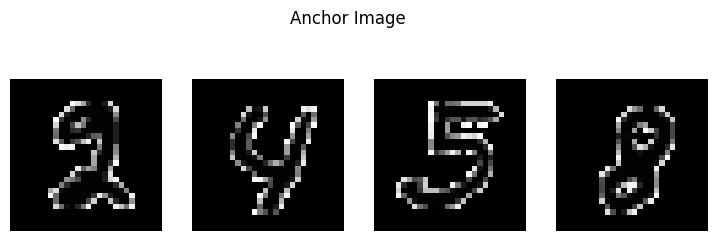

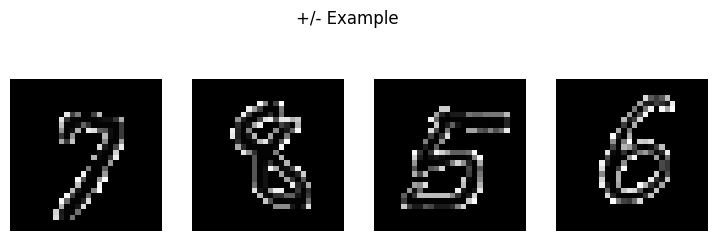

In [6]:
# Function to display images with labels
def show_images(images, title=''):
    num_images = len(images)
    fig, axes = plt.subplots(1, num_images, figsize=(9, 3))
    for i in range(num_images):
        img = images[i].reshape(28, 28)  # reshape back, since flattened
        axes[i].imshow(img, cmap='gray')
        axes[i].axis('off')
    fig.suptitle(title)
    plt.show()

# Visualize some examples
for batch_idx, (anchor_images, contrastive_images, distances, labels) in enumerate(trainLoader):
    # Convert tensors to numpy arrays
    anchor_images = anchor_images.numpy()
    contrastive_images = contrastive_images.numpy()
    labels = labels.numpy()
    
    # Display some samples from the batch
    show_images(anchor_images[:4], title='Anchor Image')
    show_images(contrastive_images[:4], title='+/- Example')
    
    # Break after displaying one batch for demonstration
    break


In [8]:
# Self write NN arch, 2 conv layers, 2 fc layers.
class ConvNet(nn.Module):
    def __init__(self):
        super().__init__()
        self.network = nn.Sequential(
            nn.Conv1d(1, 4, 3, padding=1), # 4 x 784
            nn.BatchNorm1d(4),
            nn.ReLU(),
            nn.MaxPool1d(kernel_size=2, stride=2), # 4 x 392, / 2
            nn.Conv1d(4, 8, 3, padding=1), # 8 x 392
            nn.BatchNorm1d(8),
            nn.ReLU(),
            nn.MaxPool1d(kernel_size=2, stride=2), # 8 x 196
            nn.Flatten(),
            nn.Linear(8 * 196, 256),
            nn.ReLU(),
            nn.Linear(256, 128), # made a mistake here I set it to 10 out of habit, but we want embedding so this should be embedding dims
        )
    
    def forward(self, x):
        return self.network(x)

        # return x

In [9]:
# write own loss
class ContrastiveLoss(nn.Module):
    def __init__(self):
        super().__init__()
        self.cos_similarity = nn.CosineSimilarity()
    
    def forward(self, anchor, contrastive, distance):
        sim = self.cos_similarity(anchor, contrastive) # get cos similarity between the 2 embeddings
        # distance is the ideal value. 1 if anchor and contrastive is identical, 0 vice versa hence,
        loss = torch.abs(distance - sim) # I implemented l1 loss, instead of l2 loss in the example
        return loss.mean()

Will copy the below, since it's pretty boilerplate

In [10]:
net = ConvNet()

device = 'cpu'
if torch.cuda.is_available():
    device = torch.device('cuda:0')
    
net = net.to(device)
device

'cpu'

In [11]:
# Define the training configuration
optimizer = optim.Adam(net.parameters(), lr=0.005)
loss_function = ContrastiveLoss()
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.3)

In [12]:
import os

# Define a directory to save the checkpoints
checkpoint_dir = 'checkpoints/'

# Ensure the directory exists
if not os.path.exists(checkpoint_dir):
    os.makedirs(checkpoint_dir)

In [13]:
def train_model(epoch_count=10):#
    net = ConvNet()
    lrs = []
    losses = []

    for epoch in range(epoch_count):
        epoch_loss = 0
        batches=0
        print('epoch -', epoch)
        lrs.append(optimizer.param_groups[0]['lr'])
        print('learning rate', lrs[-1])
    
        for anchor, contrastive, distance, label in tqdm(trainLoader): # as expected, label isn't actually used when training.
            batches += 1
            optimizer.zero_grad()
            anchor_out = net(anchor.to(device))
            contrastive_out = net(contrastive.to(device))
            distance = distance.to(torch.float32).to(device)
            loss = loss_function(anchor_out, contrastive_out, distance)
            epoch_loss += loss
            loss.backward()
            optimizer.step()

        losses.append(epoch_loss.cpu().detach().numpy() / batches)
        scheduler.step()
        print('epoch_loss', losses[-1])
    
        # Save a checkpoint of the model
        checkpoint_path = os.path.join(checkpoint_dir, f'model_epoch_{epoch}.pt')
        torch.save(net.state_dict(), checkpoint_path)

    return {
        "net": net,
        "losses": losses
    }

In [ ]:
result = train_model()

epoch - 0
learning rate 0.005


  1%|          | 26/2563 [00:18<29:39,  1.43it/s]